# Vigiliant Asset Allocation with momentum
## Use Index of representative asset classes
#### Market Index ETF, sector etf, bond etf are included
#### Result is driven from 2010 to 2021 market data


In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import pandas as pd
import numpy as np

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import momentum_rebalance_strategy

%matplotlib inline
from matplotlib import pyplot as plt

import quantstats

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [42]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22

    # Defensive Assets
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEI",  # iShares 3-7 Year Treasury Bond ETF                    2007-01-05
    "BND",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    ]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

In [43]:
# for weekly rebalance strategy
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()

# to draw benchmark
data_setting = {
    'start' : '2007-01-01',
    'end' : '2022-03-01',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1W',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [44]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [45]:
def get_momentum(yld_df):
    """
    yiled_df : dataframe with weekly yield of asset classes
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # data set consists of weekly data, 52 weeks per year = 12 month per year
            if i > 52 :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                current = yld_df[asset].iloc[i]
                before_1m = yld_df[asset].iloc[i-4]
                before_3m = yld_df[asset].iloc[i-13]
                before_6m = yld_df[asset].iloc[i-26]
                before_12m = yld_df[asset].iloc[i-52]

                momentum.loc[date, asset] = 12*(current/before_1m - 1) + 4*(current/before_3m - 1) \
                                            + 2*(current/before_6m - 1) + 1*(current/before_12m - 1)
            else:
                momentum.loc[date, asset] = 0
            i = i + 1

    # abnormal data processing
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)

    return momentum

def select_sector(yld_df):

    momentum_df = get_momentum(yld_df)

    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4'],
        index=momentum_df.index
    )

    selectable_asset = [
    # Offensive
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    # Defensive
    "SHY",  # iShares 1-3 Year Treasury Bond ETF                    2002-07-22
    "IEI",  # iShares 3-7 Year Treasury Bond ETF                    2007-01-05
    "BND",  # iShares 7-10 Year Treasury Bond ETF                   2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    ]

    for date in momentum_df.index:
        snp_momentum = momentum_df.loc[date,'IVV']
        dev_momentum = momentum_df.loc[date,'VEA']
        eme_momentum = momentum_df.loc[date,'VWO']
        bnd_momentum = momentum_df.loc[date,'LQD']

        short_momentum = momentum_df.loc[date,'SHY']
        mid_momentum = momentum_df.loc[date,'IEI']
        long_momentum = momentum_df.loc[date,'BND']
        tip_momentum = momentum_df.loc[date,'TIP']

        # sorted_momentum = momentum_df[selectable_asset].loc[date].sort_values(ascending=False)

        if snp_momentum >= 0 and dev_momentum >= 0 and eme_momentum >= 0 and bnd_momentum >= 0:
            selected_momentum.loc[date,'momentum_1'] = snp_momentum
            selected_ticker.loc[date,'momentum_1'] = 'IVV'

            selected_momentum.loc[date,'momentum_2'] = dev_momentum
            selected_ticker.loc[date,'momentum_2'] = 'VEA'

            selected_momentum.loc[date,'momentum_3'] = eme_momentum
            selected_ticker.loc[date,'momentum_3'] = 'VWO'

            selected_momentum.loc[date,'momentum_4'] = bnd_momentum
            selected_ticker.loc[date,'momentum_4'] = 'LQD'

        else:
            selected_momentum.loc[date,'momentum_1'] = short_momentum
            selected_ticker.loc[date,'momentum_1'] = 'SHY'

            selected_momentum.loc[date,'momentum_2'] = mid_momentum
            selected_ticker.loc[date,'momentum_2'] = 'IEI'

            selected_momentum.loc[date,'momentum_3'] = long_momentum
            selected_ticker.loc[date,'momentum_3'] = 'BND'

            selected_momentum.loc[date,'momentum_4'] = tip_momentum
            selected_ticker.loc[date,'momentum_4'] = 'TIP'

    return selected_ticker


def vaa_momentum(yld_df):
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in mom_ticker_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/4
    mp_table = mp_table.fillna(0)
    return mp_table

In [46]:
mp_table_result = vaa_momentum(yield_df)

In [47]:
def trim_data(yld_df, mp_table, benchmark_yield_df):

    yld_df = yld_df.iloc[52 + 1:]
    mp_table = mp_table.iloc[52 + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[52 + 1:]
    return yld_df, mp_table, benchmark_yield_df

In [48]:
yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)

In [49]:
print("frequency of portfolio")
mp_table_result.sum() * 2

frequency of portfolio


IVV      2.5
VEA      2.5
VWO      2.5
LQD      2.5
SHY    352.0
IEI    352.0
BND    352.0
TIP    352.0
dtype: float64

In [50]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=vaa_momentum, yld_df=yield_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy = rebal_strategy.iloc[52:]
rebal_strategy

,strategy_return,benchmark_return,IVV,VEA,VWO,LQD,SHY,IEI,BND,TIP,SUM
Date,,,,,,,,,,,
2009-08-09,0.033458,-0.02061,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.00,1.0
2009-08-16,-0.01115,-0.009471,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0
2009-08-23,0.008835,-0.010889,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0
2009-08-30,0.002537,0.002896,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0
2009-09-06,0.002181,-0.016394,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-06,-0.001609,0.001903,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0
2022-02-13,-0.008887,0.006484,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0
2022-02-20,-0.006225,0.006432,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.25,1.0


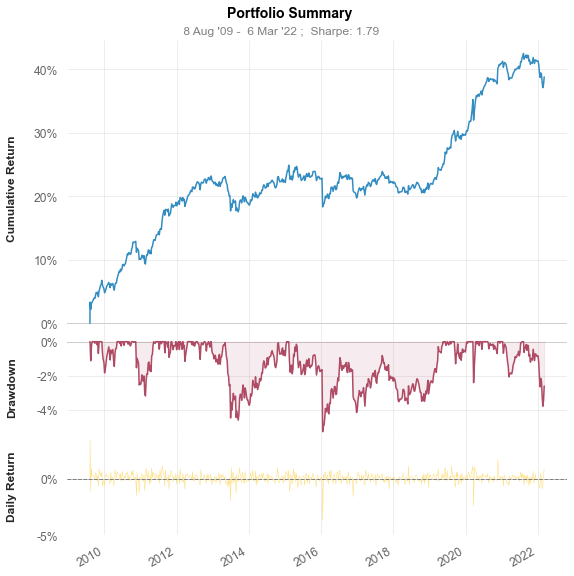

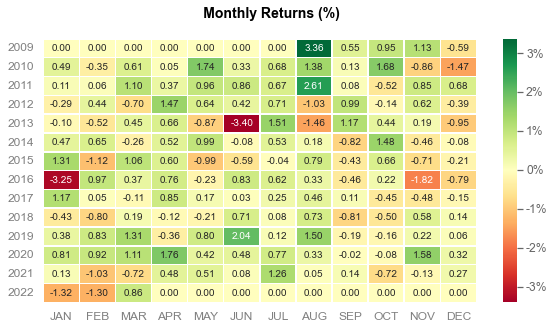

In [51]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

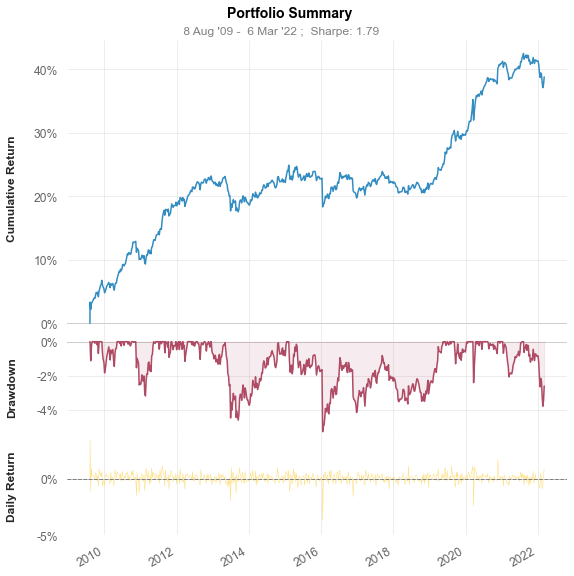

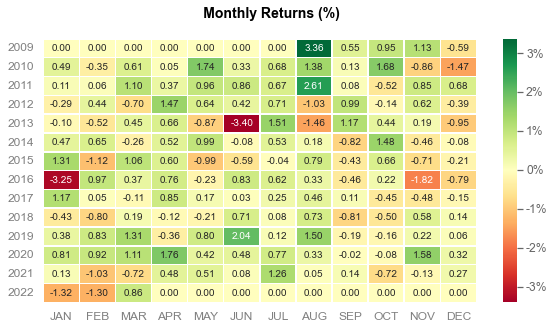

In [52]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-08-09  2009-08-09
End Period                 2022-03-06  2022-03-06
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          38.81%      172.42%
CAGR﹪                     2.64%       8.29%

Sharpe                     1.79        2.61
Smart Sharpe               1.6         2.33
Sortino                    2.56        3.86
Smart Sortino              2.29        3.46
Sortino/√2                 1.81        2.73
Smart Sortino/√2           1.62        2.44
Omega                      1.39        1.39

Max Drawdown               -5.26%      -9.11%
Longest DD Days            1554        483
Volatility (ann.)          7.19%       15.21%
R^2                        0.0         0.0
Calmar                     0.5         0.91
Skew                       -0.77       -0.67
Kurtosis                   12.87       7.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-02-15,2016-01-17,2019-05-19,1554,-5.261343,-4.443094
2,2012-12-23,2013-09-15,2015-01-18,756,-4.588075,-4.431167
3,2021-08-15,2022-02-20,2022-03-06,203,-3.776328,-3.420373
4,2010-11-21,2011-02-20,2011-05-15,175,-3.167371,-3.041207
5,2020-03-22,2020-03-22,2020-04-12,21,-2.394962,-1.420338


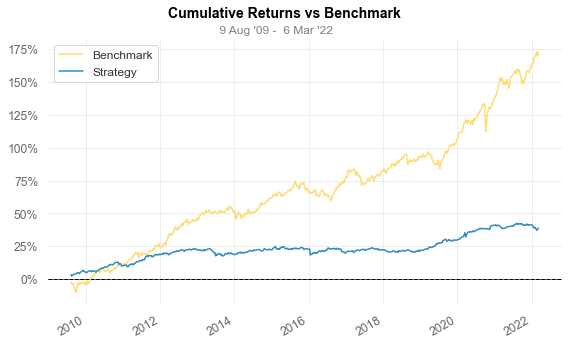

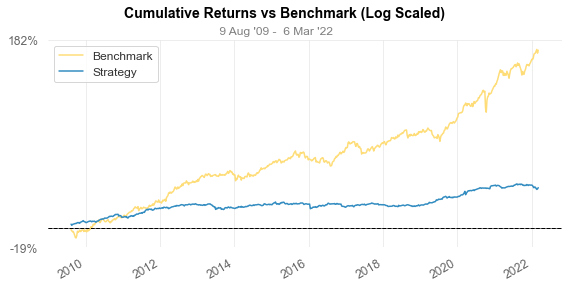

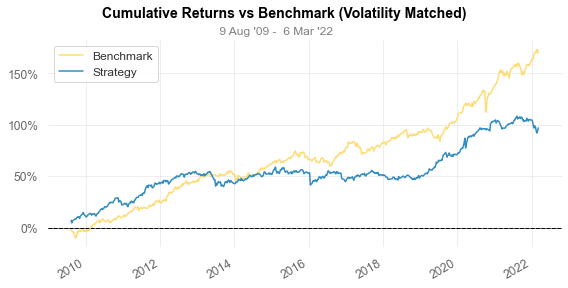

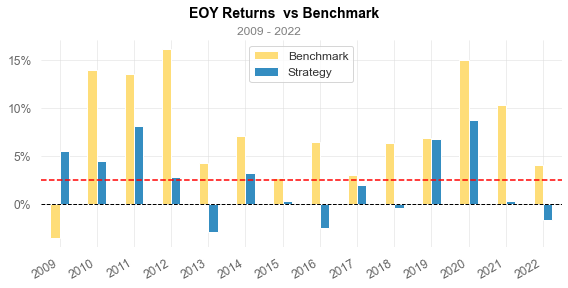

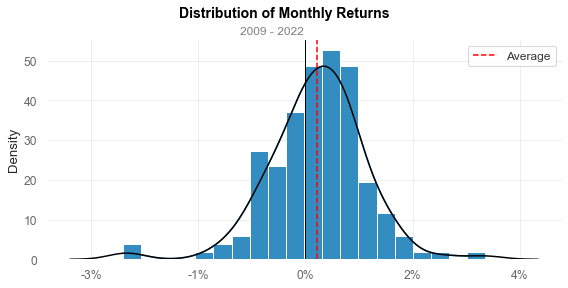

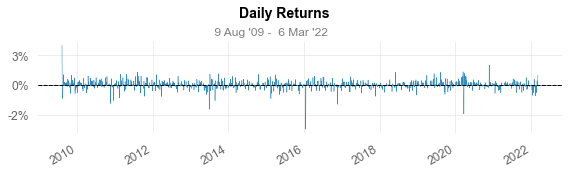

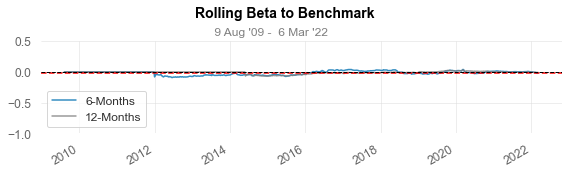

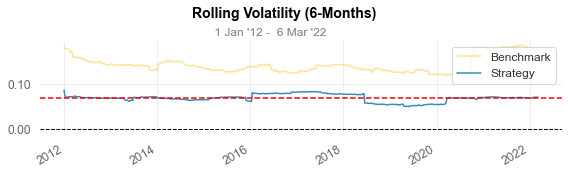

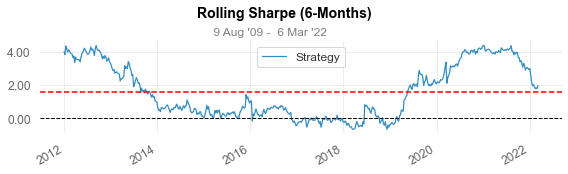

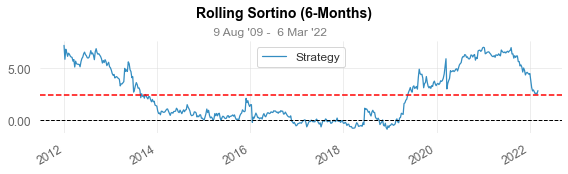

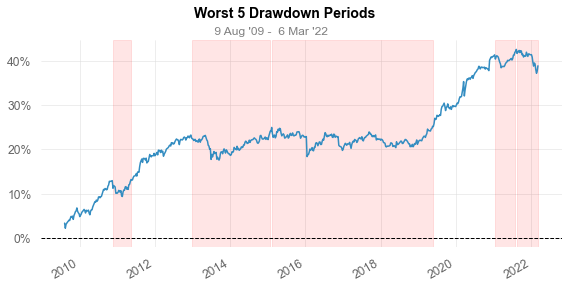

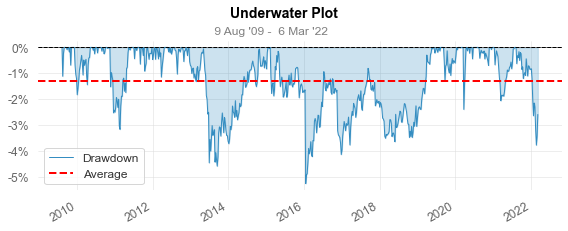

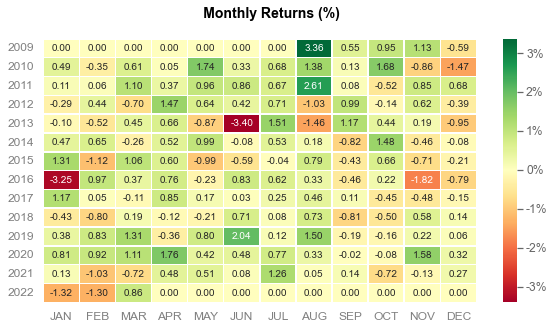

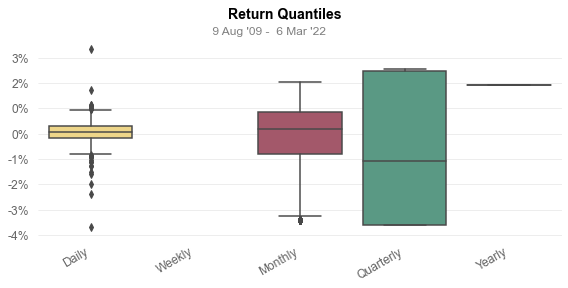

In [53]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)


In [54]:
canaria = yield_df[['IVV','VEA','VWO','LQD']]
canaria.corr()

,IVV,VEA,VWO,LQD
IVV,1.000000,0.910082,0.812310,0.232966
VEA,0.910082,1.000000,0.888363,0.232374
VWO,0.812310,0.888363,1.000000,0.183169
LQD,0.232966,0.232374,0.183169,1.000000


In [55]:
snp_dev_same_direction = len(canaria[canaria['IVV'] * canaria['VEA'] >= 0])
snp_em_same_direction = len(canaria[canaria['IVV'] * canaria['VWO'] >= 0])
snp_bnd_same_direction = len(canaria[canaria['IVV'] * canaria['LQD'] >= 0])
print("same direction rate follows : ")
print("developed market : " ,snp_dev_same_direction/len(canaria))
print("emerging market : " ,snp_em_same_direction/len(canaria))
print("corp bond market : " ,snp_bnd_same_direction/len(canaria))


same direction rate follows : 
developed market :  0.8166431593794076
emerging market :  0.7503526093088858
corp bond market :  0.538787023977433


## Why this strategy always escape from market
#### --------------------                 Right Way Rate %
#### Total Bond Market      81.66%
#### Emerging Market        75.04%
#### Corp Bond      53.88%

#### canaria option acts if any canaria condition satisfied.
wrong way pattern of corporate bond market triggered sategy pin too often,
this means that corporate bond market triggered the strategy to escape from market,
meaning that huge opportunity cost from rising developed equity market
